In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [29]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
y_test = y_test.reshape(y_test.shape[0], 1)

In [14]:
zoom_range=(1, 4) # define zoom range
# Create ImageDataGenerator training instance with data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   zoom_range=zoom_range, # zoom into the image
                                   width_shift_range=0.3, # shift the image width ways
                                   height_shift_range=0.3) # shift the image height ways

In [16]:
train_datagen.fit(X_train.reshape(X_train.shape[0], 28, 28, 1))

In [17]:
# define number of rows & columns
num_row = 2
num_col = 8
num = num_row*num_col

AFTER:



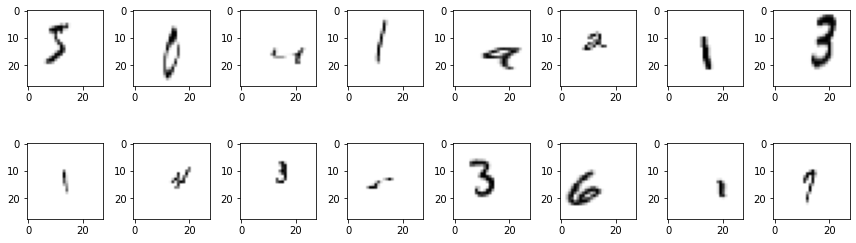

In [30]:
print('AFTER:\n')
fig2, axes2 = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for X, Y in train_datagen.flow(X_train.reshape(X_train.shape[0], 28, 28, 1),y_train.reshape(y_train.shape[0], 1),batch_size=num,shuffle=False):
     for i in range(0, num):
          ax = axes2[i//num_col, i%num_col]
          ax.imshow(X[i].reshape(28,28), cmap='gray_r')
     break
plt.tight_layout()
plt.show()

In [33]:
X_train_aug = train_datagen.flow(X_train.reshape(X_train.shape[0], 28, 28, 1),y_train.reshape(y_train.shape[0], 1),batch_size=num,shuffle=False)

In [34]:
model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1),
                 padding="same"))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               1605760   
                                                      

In [35]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=['accuracy'])


history = model.fit(X_train_aug, epochs=10, batch_size=256, validation_data=(X_test, y_test))


Epoch 1/10
3749/3750 [============================>.] - ETA: 0s - loss: 27445667840.0000 - accuracy: 0.1310

ValueError: in user code:

    File "/home/karol/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1525, in test_function  *
        return step_function(self, iterator)
    File "/home/karol/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1514, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/karol/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1507, in run_step  **
        outputs = model.test_step(data)
    File "/home/karol/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1473, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/karol/.local/lib/python3.9/site-packages/keras/engine/training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "/home/karol/.local/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/karol/.local/lib/python3.9/site-packages/keras/losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/karol/.local/lib/python3.9/site-packages/keras/losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/karol/.local/lib/python3.9/site-packages/keras/losses.py", line 1789, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/karol/.local/lib/python3.9/site-packages/keras/backend.py", line 5083, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 10) are incompatible


Text(0.5, 0, 'epochs')

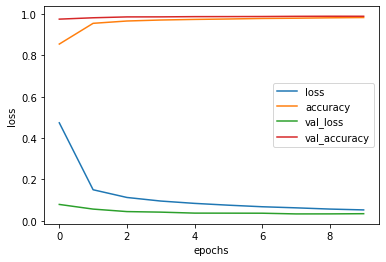

In [12]:
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")

In [13]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0345 - accuracy: 0.9898


[0.03452508896589279, 0.989799976348877]

In [14]:
model.save("model.h5")